<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import numpy as np

In [3]:
print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns first dependency:", 
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependency:", 
      -0.5 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      -0.25 * (2 * 0.5 * np.log(0.5) - 0.25 * (0)))

Expected cross entropy loss if the model:
- learns neither dependency: 0.661563238158
- learns first dependency: 0.519166699707
- learns both dependency: 0.454454367449


In [4]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES']=''

In [5]:
num_steps = 5
batch_size = 200
num_classes = 2
state_size = 16
learning_rate = 0.001

In [6]:
def gen_data(size = 1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)
        

In [7]:
def gen_batch(raw_date, batch_size, num_steps):
    raw_x, raw_y = raw_date
    data_length = len(raw_x)
    
    #partition raw data into batches and stak them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    # do partition 
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i : batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i : batch_partition_length * (i + 1)]
    # do epoch
    epoch_size = batch_partition_length // num_steps
    
    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield(x, y)
        
def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [8]:
tf.reset_default_graph()

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis = 1)

In [9]:
# with tf.variable_scope('rnn_cell'):
#     W = tf.get_variable('W', [num_classes + state_size, state_size])
#     b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

# def rnn_cell(rnn_input, state):
#     with tf.variable_scope('rnn_cell', reuse=True):
#         W = tf.get_variable('W', [num_classes + state_size, state_size])
#         b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
#     return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)
    
# state = init_state
# rnn_outputs = []
# for rnn_input in rnn_inputs:
#     state = rnn_cell(rnn_input, state)
#     rnn_outputs.append(state)
# final_state = rnn_outputs[-1]

# 上面是原始代码，定义了rnn_cell，然后使用循环的方式对其进行复用，
#利用tensorflow简化之后我们可以直接调用BasicRNNCell和static_rnn两个函数实现
cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.static_rnn(cell, rnn_inputs, initial_state=init_state)
print(rnn_outputs)
print(final_state)

[<tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh:0' shape=(200, 16) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_1:0' shape=(200, 16) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_2:0' shape=(200, 16) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_3:0' shape=(200, 16) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_4:0' shape=(200, 16) dtype=float32>]
Tensor("rnn/rnn/basic_rnn_cell/Tanh_4:0", shape=(200, 16), dtype=float32)


In [10]:
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, num=num_steps, axis=1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for 
         logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)



EPOCH 0
Average loss at step 100 for last 100 steps: 0.60592177242
Average loss at step 200 for last 100 steps: 0.494117258489
Average loss at step 300 for last 100 steps: 0.487235401273
Average loss at step 400 for last 100 steps: 0.488104067743
Average loss at step 500 for last 100 steps: 0.484612516463
Average loss at step 600 for last 100 steps: 0.485257371664
Average loss at step 700 for last 100 steps: 0.484761792421
Average loss at step 800 for last 100 steps: 0.484488342404
Average loss at step 900 for last 100 steps: 0.482228897214

EPOCH 1
Average loss at step 100 for last 100 steps: 0.490588644147
Average loss at step 200 for last 100 steps: 0.484489214122
Average loss at step 300 for last 100 steps: 0.483278390467
Average loss at step 400 for last 100 steps: 0.479197616577
Average loss at step 500 for last 100 steps: 0.480221810639
Average loss at step 600 for last 100 steps: 0.477422969341
Average loss at step 700 for last 100 steps: 0.479821939468
Average loss at step 80

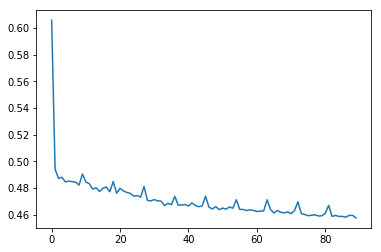

In [11]:
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _= \
                    sess.run([losses, 
                              total_loss,
                              final_state,
                              train_step],
                            feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 100 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
    return training_losses
training_losses = train_network(10, num_steps, state_size=state_size)
plt.plot(training_losses)
            